## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import pickle
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
import json

C:\Users\dom\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Features table

In [2]:
data = pd.read_csv('ready_data.csv')

In [3]:
Features = data[['stories', 'fireplace', 'sqft', 'PrivatePool',
                 'Year built', 'Remodeled year', 'baths/bed',
                 'Parking', 'school_rating', 'density', 'status', 'propertyType']]
target = data.Price

In [4]:
Features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214022 entries, 0 to 214021
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   stories         214022 non-null  int64  
 1   fireplace       214022 non-null  int64  
 2   sqft            214022 non-null  float64
 3   PrivatePool     214022 non-null  int64  
 4   Year built      214022 non-null  int64  
 5   Remodeled year  214022 non-null  int64  
 6   baths/bed       214022 non-null  float64
 7   Parking         214022 non-null  int64  
 8   school_rating   214022 non-null  int64  
 9   density         214022 non-null  float64
 10  status          214022 non-null  int64  
 11  propertyType    214022 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 19.6 MB


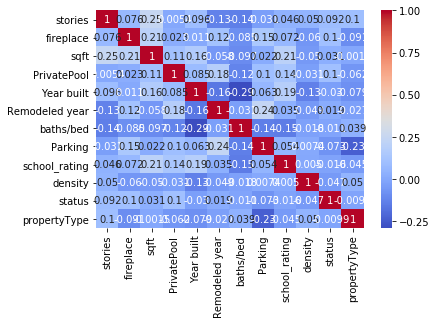

In [5]:
sns.heatmap(Features.corr(), annot=True, cmap='coolwarm')
#most of the variables have low correlation

# Model

In [6]:
scaler = StandardScaler()
FeaturesSt = scaler.fit_transform(Features)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(FeaturesSt, target, random_state=42, test_size=0.2)
print('X_train:', X_train.shape, type(X_train))
print('X_test:', X_test.shape)
print('y_train:', y_train.shape, type(y_train))
print('y_test:', y_test.shape)

X_train: (171217, 12) <class 'numpy.ndarray'>
X_test: (42805, 12)
y_train: (171217,) <class 'pandas.core.series.Series'>
y_test: (42805,)


In [8]:
LR =  LinearRegression()
DTR = DecisionTreeRegressor(max_depth=10, criterion='mae', random_state=42)
RFR = RandomForestRegressor(max_depth=20, random_state=42)
ABR = AdaBoostRegressor(LR, n_estimators=500, learning_rate=0.8)

In [9]:
#Parameters for LR
distributions={
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'n_jobs': [-1, 5, None]
}
LRP = RandomizedSearchCV(LR, distributions, random_state=0)
search = LRP.fit(X_train, y_train)
LRnew =  LinearRegression(**search.best_params_)

In [10]:
#Parameters for DecisionTreeRegressor(DTR)
distributions={
    'max_depth': [3, 7, 9, 17, 30, None],
    'criterion': ['mse', 'friedman_mse'],
    'random_state': [0, 42],
    'min_samples_split': [2, 4, 7],
    'min_samples_leaf': [1, 5],
    'max_features': ['auto', 'sqrt', None]
}
r = RandomizedSearchCV(DTR, distributions, random_state=0)
search = r.fit(X_train, y_train)
DTRnew = DecisionTreeRegressor(**search.best_params_)

In [11]:
#Parameters for RandomForestRegressor(RFR)
distributions={
    'n_estimators': [30, 50, 100, 120],
    'criterion': ['mse', 'friedman_mse'],
    'max_depth': [5, 10, 15, None],
    'oob_score': [True, False],
    'n_jobs': [-1, 10],
    'random_state': [0, 10, 42]
}
r = RandomizedSearchCV(RFR, distributions, random_state=0)
search = r.fit(X_train, y_train)
RFRnew = RandomForestRegressor(**search.best_params_)

In [12]:
#find optimal parameters for AdaBoostRegressor with 5 evaluations
l = ['linear', 'square', 'exponential']
be = [None, LinearRegression()]
def acc_model(params):
    reg = AdaBoostRegressor(**params)
    
    return cross_val_score(reg, X_train, y_train).mean()

param_space = {
    'base_estimator': hp.choice('base_estimator', be),
    'n_estimators': hp.choice('n_estimators', range(1, 100)), 
    'learning_rate': hp.quniform('learning_rate', 0.1, 1, 0.1),
    'loss': hp.choice('loss', l),
    'random_state': hp.choice('random_state', range(1, 50))
}

best_adab = 0
def f(params):
    global best_adab
    acc = acc_model(params)
    if acc > best_adab:
        best_adab = acc
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best_adab = fmin(f, param_space, algo=tpe.suggest, max_evals=5, trials=trials)
print ('best_adaboost_params:')
best_adab['loss'] = l[best_adab['loss']]
best_adab['base_estimator'] = be[best_adab['base_estimator']]
print (best_adab)

100%|████████| 5/5 [05:08<00:00, 59.77s/trial, best loss: -0.39287583386479225]
best_adaboost_params:
{'base_estimator': None, 'learning_rate': 0.4, 'loss': 'linear', 'n_estimators': 50, 'random_state': 24}


In [13]:
ABRnew = AdaBoostRegressor(**best_adab)

In [14]:
def compute_meta_feature(regr, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the regressor.
    
    :arg regr: scikit-learn regressor
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    X_meta_train = np.zeros_like(y_train, dtype = np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_r = clone(regr)
        folded_r.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_r.predict(X_fold_predict)
    
    meta_r = clone(regr)
    meta_r.fit(X_train, y_train)
    
    X_meta_test = meta_r.predict(X_test)
    
    return X_meta_train, X_meta_test

In [15]:
def generate_metafeatures(regrs, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of regressors.
    
    :arg regrs: list of scikit-learn regressors
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(regr, X_train, X_test, y_train, cv)
        for regr in tqdm(regrs)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

In [16]:
cv = KFold(n_splits=10, shuffle=True)
stacked_features_train, stacked_features_test = generate_metafeatures([LRnew, DTRnew, RFRnew, ABRnew],X_train, 
                                                                      X_test, y_train.values, cv)

100%|████████████████████████████████████████████| 4/4 [06:49<00:00, 99.30s/it]


In [17]:
total_features_train = np.hstack([X_train, stacked_features_train])
total_features_test = np.hstack([X_test, stacked_features_test])

In [18]:
with open('train_data.npy', 'wb') as f:
    np.save(f, total_features_train)
    np.save(f, y_train)
    np.save(f, total_features_test)
    np.save(f, y_test)

In [19]:
random_value = np.random.choice(len(total_features_test))
columns = Features.columns.values.tolist()
columns.extend(['lr', 'dtr', 'rfr', 'abr'])
dft = pd.DataFrame(total_features_test[random_value].reshape(1,16), columns=columns)

In [20]:
json_test = dft.to_json(orient="records")
with open('test_example.json', 'w') as json_file:
    json.dump(json_test, json_file)